# Import Packages, Grab Data via Script

In [1]:
!pip install pybaseball
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 47.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00


In [2]:
%run data.py
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 150/150 [02:31<00:00,  1.01s/it]
/content/data.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

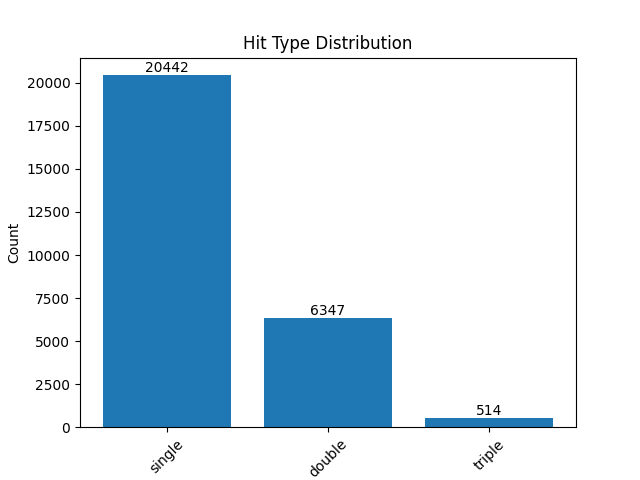

In [24]:
# Create a new figure
fig, ax = plt.subplots()

# Create a bar plot
bars = ax.bar(['single','double','triple'], height = hits['events'].value_counts()[:])

# Set labels and title
plt.xlabel('Hit Type')
plt.ylabel('Count')
plt.title('Hit Type Distribution')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Attach count labels to each bar
plt.bar_label(bars, fmt='%d', label_type='edge')

# Display the plot
plt.show()

In [4]:
# Pairplot by hit-type, investigate differences

#sns.pairplot(hits[hits.events == 'single'].iloc[:,3:],plot_kws={'color': 'green'})
#sns.pairplot(hits[hits.events == 'double'].iloc[:,3:],plot_kws={'color': 'red'})
#sns.pairplot(hits[hits.events == 'triple'].iloc[:,3:],plot_kws={'color': 'blue'})

# Analysis with Unsupervised ML

## Preprocessing

In [5]:
# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'sprint_speed','distance']
categorical_features = ['home_team']

# Define preprocessing ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)

In [6]:
# Creates cheat-sheet of  pitches and corresponding value after being encoded
outcomes = pd.DataFrame()
outcomes['Hit Type'] = label_encoder.inverse_transform(list(set(y)))
outcomes['Encoded'] = list(set(y))

print(outcomes)

  Hit Type  Encoded
0   double        0
1   single        1
2   triple        2


## Gaussian Mixture Models

In [30]:
def evaluate_GMMs(models, preprocessor, X_train, X_test, y_train, y_test, metrics):
  # Create an empty DataFrame to store the metrics
  results_df = pd.DataFrame(columns=list(metrics.keys()))

  # Iterate over models
  for z, (name, model) in enumerate(models):
      print('Evaluating...', name)

      # Create the pipeline
      pipeline = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('classifier', model)
      ])


      # Train the pipeline
      pipeline.fit(X_train)

      # Make predictions on the test set
      y_pred = pipeline.predict(X_test)
      y_pred_proba = pipeline.predict_proba(X_test)


      # Calculate and store the metrics for the classifier
      results = {key: None for key in metrics.keys()}


      # Add all metrics to dictionary, add to DataFrame
      for metric_name, metric_func in metrics.items():
          if metric_name == 'Homogeneity Score':
            metric_value = metric_func(y_test, y_pred)
          elif metric_name == 'Silhouette Score' and len(np.unique(y_pred)) >= 2:
            metric_value = metric_func(pipeline.named_steps['preprocessor'].transform(X_test), y_pred)
          elif metric_name == 'AIC':
            metric_value = model.aic(pipeline.named_steps['preprocessor'].transform(X_test))
          elif metric_name == 'BIC':
            metric_value = model.bic(pipeline.named_steps['preprocessor'].transform(X_test))

          results[metric_name] = metric_value


      #print(results)

      # Add the results to the DataFrame
      results_df.loc[name] = pd.Series(results)

  # Create a new figure
  fig, ax = plt.subplots()

  ax.plot(np.arange(1, 21), results_df['AIC'], label='AIC')
  ax.plot(np.arange(1, 21), results_df['BIC'], label='BIC')
  ax.legend(loc='best')
  ax.set_xlabel('Number of Components')
  ax.set_ylabel('AIC/BIC Score')
  ax.set_title('GMM Components vs. AIC/BIC')
  plt.show()

  return results_df

In [8]:
# Very little correlation between any two variables except for distance and EV (no surprise)
# Informs Diagonal Covariance for GMM models
X.iloc[:, 2:].corr()

,launch_speed,launch_angle,angle,distance,sprint_speed
launch_speed,1.000000,0.143733,-0.054606,0.536085,-0.045403
launch_angle,0.143733,1.000000,-0.137103,0.597471,-0.069967
angle,-0.054606,-0.137103,1.000000,-0.069964,0.023764
distance,0.536085,0.597471,-0.069964,1.000000,-0.072100
sprint_speed,-0.045403,-0.069967,0.023764,-0.072100,1.000000


In [9]:
# Define the classifiers
gmm_models = [(f'GMM, {n} components', GaussianMixture(n_components=n, covariance_type='diag', n_init = 10)) for n in np.arange(1, 21)]


# Define the metrics
gmm_metrics = {
    'AIC': None,
    'BIC': None,
    'Homogeneity Score': homogeneity_score,
    'Silhouette Score': silhouette_score,
}

Evaluating... GMM, 1 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 2 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 3 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 4 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 5 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 6 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 7 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 8 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 9 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 10 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 11 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 12 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 13 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 14 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 15 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 16 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 17 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 18 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 19 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... GMM, 20 components


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


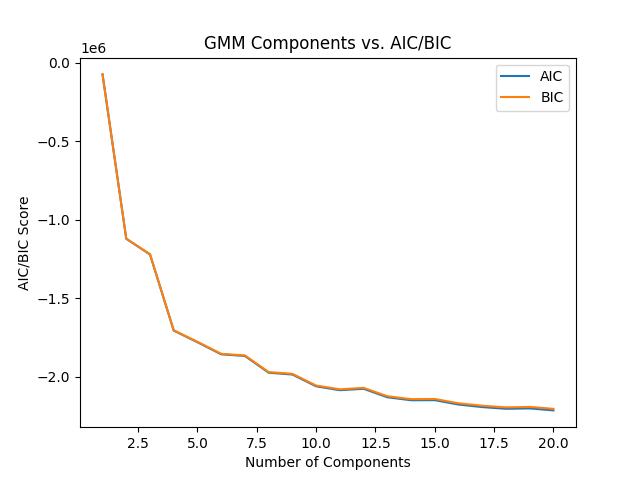

,AIC,BIC,Homogeneity Score,Silhouette Score
"GMM, 1 components",-7.430742e+04,-7.381577e+04,0.000000,0.000000
"GMM, 2 components",-1.121784e+06,-1.120793e+06,0.000180,0.012772
"GMM, 3 components",-1.221689e+06,-1.220201e+06,0.000376,0.005196
"GMM, 4 components",-1.706873e+06,-1.704886e+06,0.000568,0.013754
"GMM, 5 components",-1.781001e+06,-1.778516e+06,0.001116,0.017440
"GMM, 6 components",-1.857958e+06,-1.854974e+06,0.001341,0.016066
"GMM, 7 components",-1.868546e+06,-1.865063e+06,0.004441,-0.006525
"GMM, 8 components",-1.975347e+06,-1.971366e+06,0.001163,0.032946
"GMM, 9 components",-1.986926e+06,-1.982447e+06,0.001859,0.028858
"GMM, 10 components",-2.061937e+06,-2.056959e+06,0.002087,0.041676


In [31]:
gmm_df = evaluate_GMMs(gmm_models, preprocessor, X_train, X_test, y_train, y_test, gmm_metrics)
gmm_df

## PCA (2 and 3 components)

In [11]:
def plot_PCAs(pca_2, pca_3, y, data_desc):
  fig = plt.figure(figsize=(15, 10))

  # Create the first subplot (2D)
  ax1 = fig.add_subplot(121)
  # Create the second subplot (3D)
  ax2 = fig.add_subplot(122, projection='3d')

  # Plotting
  colors = ['r', 'g', 'b']
  class_labels = list(range(3))

  # Create a scatter plot for each class
  for class_label, color in zip(class_labels, colors):
      class_indices = np.where(y == class_label)

      ax1.scatter(pca_2[class_indices, 0], pca_2[class_indices, 1], color=color, label=f"Class {label_encoder.inverse_transform([class_label])[0]}")
      ax2.scatter(pca_3[class_indices, 0], pca_3[class_indices, 1], pca_3[class_indices, 2], color=color, label=f"Class {label_encoder.inverse_transform([class_label])[0]}")

  ax1.legend()
  ax1.set_xlabel('Principal Component 1')
  ax1.set_ylabel('Principal Component 2')
  ax1.set_title(f'PCA 2 Components ({data_desc})')

  ax2.set_xlabel('Principal Component 1')
  ax2.set_ylabel('Principal Component 2')
  ax2.set_zlabel('Principal Component 3')
  ax2.legend()
  ax2.set_title(f'PCA 3 Components ({data_desc})')
  ax2.view_init(elev=20, azim=210)

  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


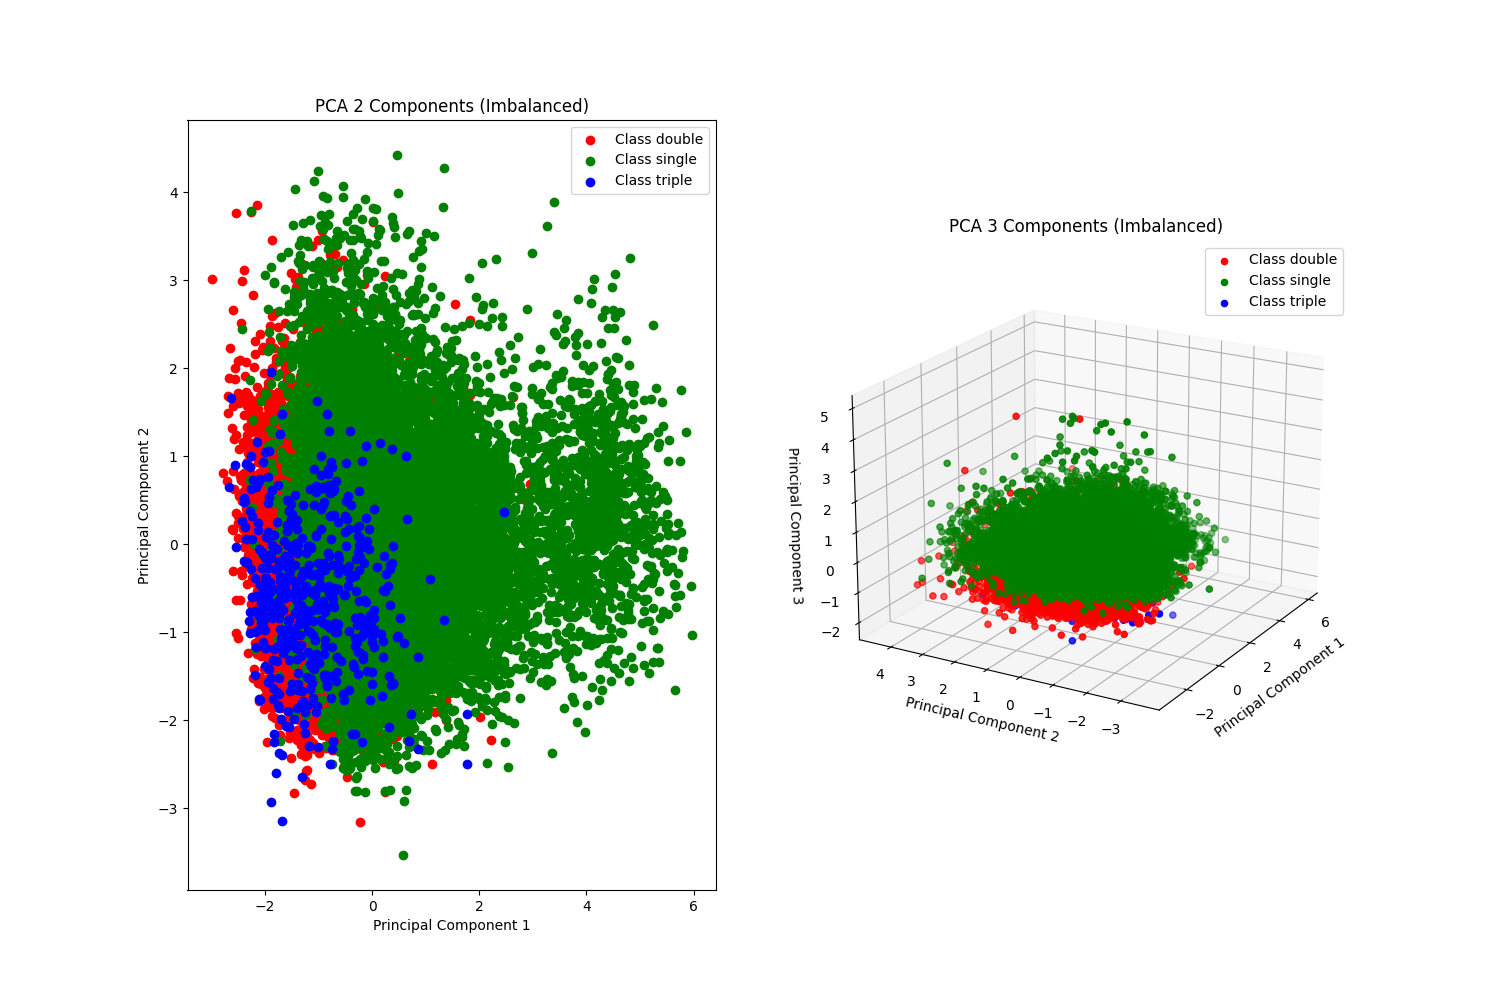

In [27]:
X_transformed = preprocessor.fit_transform(X)

# Perform PCA to reduce data to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Perform PCA to reduce data to 2 components
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_transformed)

plot_PCAs(X_pca, X_pca3, y, 'Imbalanced')

### Resampled PCA

In [28]:
rus = RandomUnderSampler(random_state=69)
print('Counts of 2B, 1B, 3B (Imbalanced)', np.unique(y, return_counts = True)[1])

X_resample, y_resample = rus.fit_resample(preprocessor.fit_transform(X), y)
print('Counts of 2B, 1B, 3B (Undersampled)', np.unique(y_resample, return_counts = True)[1])

Counts of 2B, 1B, 3B (Imbalanced) [ 6347 20442   514]
Counts of 2B, 1B, 3B (Undersampled) [514 514 514]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


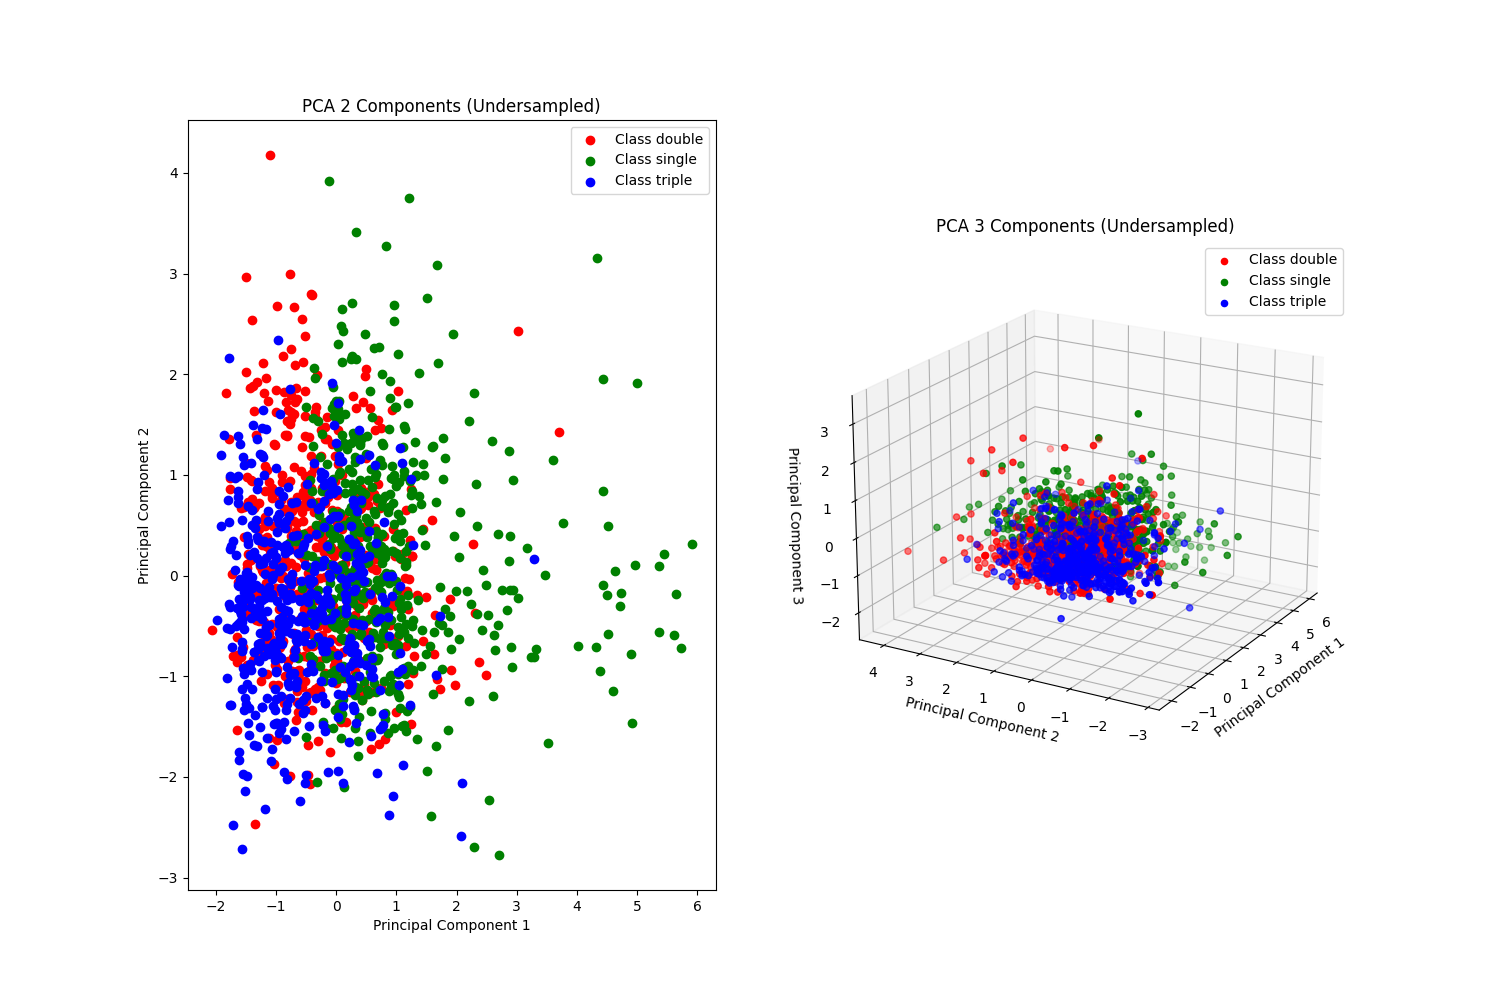

In [29]:
# Perform PCA to reduce data to 2 components
pca_resample = PCA(n_components=2)
X_pca_resample = pca_resample.fit_transform(X_resample)

# Perform PCA to reduce data to 2 components
pca3_resample = PCA(n_components=3)
X_pca3_resample = pca3_resample.fit_transform(X_resample)


plot_PCAs(X_pca_resample, X_pca3_resample, y_resample, 'Undersampled')